## 1. import libraries

In [32]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve




from xgboost import XGBRegressor


from feature_engine.datetime import DatetimeFeatures
import joblib 
import matplotlib.pyplot as plt 

## 2. Display settings

In [33]:
pd.set_option('display.max_columns',None)

In [34]:
sklearn.set_config(transform_output='default')

## 3. Get data

In [35]:
train_df=pd.read_csv('Data/flight_train_flask_ml.csv')
val_df=pd.read_csv('Data/flight_val_flask_ml.csv')
test_df=pd.read_csv('Data/flight_test_flask_ml.csv')

In [36]:
train_df.shape

(640, 10)

In [37]:
val_df.shape

(160, 10)

### 3.1 Split data

In [38]:
def split_data(data):
    X=data.drop(columns='price')
    y=data.price.copy()
    return (X,y)
    

In [39]:
X_train,y_train=split_data(train_df)

In [40]:
X_val,y_val=split_data(val_df)
print(X_val.shape,y_val.shape)
X_test,y_test=split_data(test_df)
print(X_test.shape,y_test.shape)

(160, 9) (160,)
(200, 9) (200,)


### 3.2 Meta info

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4. Data preprocessing

In [42]:
# change the data type of columns
dt_cols=['date_of_journey','dep_time','arrival_time']
num_cols=['duration','total_stops']
cat_cols=[col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols) ]


In [43]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [44]:
num_transformer=Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer=Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

doj_transformer=Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='most_frequent')),
    ('extractor', DatetimeFeatures(features_to_extract=['month','week','day_of_week','day_of_month'],format='mixed')),
    ('scaler', StandardScaler())])


time_transformer=Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='most_frequent')),
    ('extractor', DatetimeFeatures(features_to_extract=['hour','minute'],format='mixed')),
    ('scaler', StandardScaler())])

In [45]:
preprocessor=ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols),
    ('doj', doj_transformer,['date_of_journey']),
    ('time',time_transformer,['dep_time','arrival_time'])
])

In [46]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

## 5. Model selection

In [47]:
algorithms={
    'Linear Regression': LinearRegression(),
    'Support Vector Machine': SVR(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=10),
    'Xgboost': XGBRegressor(n_estimators=10)
}

In [48]:
data=pd.concat([train_df,val_df],axis=0)
X_data,y_data=split_data(data)
X_data.shape,y_data.shape

((800, 9), (800,))

In [49]:
def plot_curve(sizes,mean_scores,std_scores,label,ax):
    ax.plot(
        sizes,
        mean_scores,
        marker='o',
        label=label
    )
    ax.fill_between(
        x=sizes,
        y1=mean_scores-std_scores,
        y2=mean_scores+std_scores,
        alpha=0.5
    )

In [50]:
def plot_learning_curve(name,algorithms,figsize=(12,4)):
    model=Pipeline(steps=[
        ('pre',preprocessor),
        ('alg',algorithms)
    ])
    train_sizes,train_scores,test_scores=learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )
    mean_train_scores=np.mean(train_scores,axis=1)
    std_train_scores=np.std(train_scores,axis=1)
    train_score=f"{mean_train_scores[-1]:.2f}+/-{std_train_scores[-1]:.2f}"
    
    mean_test_scores=np.mean(test_scores,axis=1)
    std_test_scores=np.std(test_scores,axis=1)
    test_score=f"{mean_test_scores[-1]:.2f}+/-{std_test_scores[-1]:.2f}"

    fig,ax=plt.subplots(figsize=figsize)

    # training curve
    plot_curve(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train({train_score})",
        ax
    )
    # test_curve
    plot_curve(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Train({test_score})",
        ax
    )

    ax.set(xlabel="Training set size",ylabel="R-square",title=name)
    ax.legend(loc="lower right")
    plt.show()




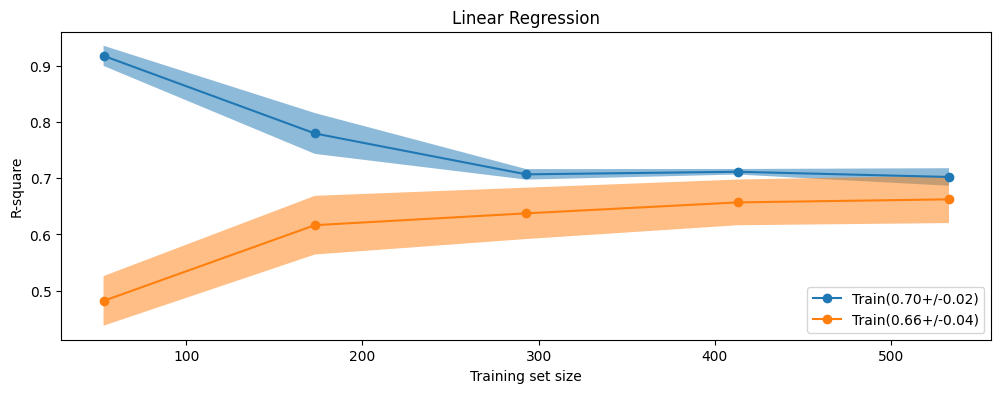

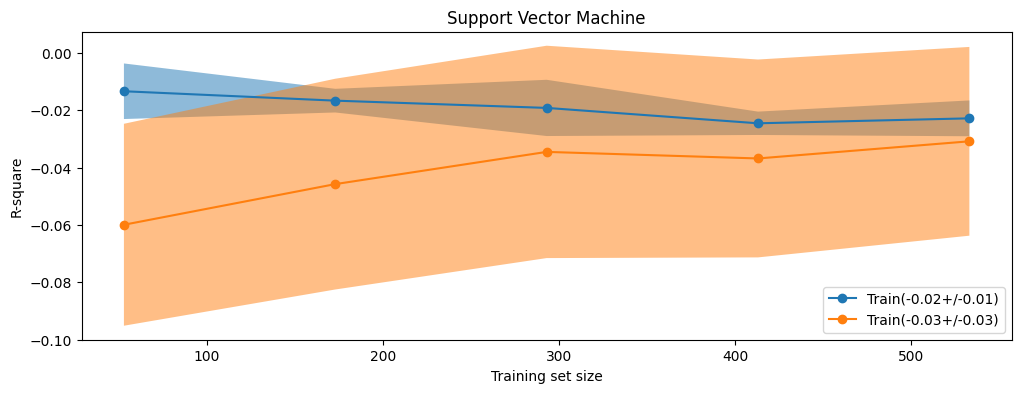

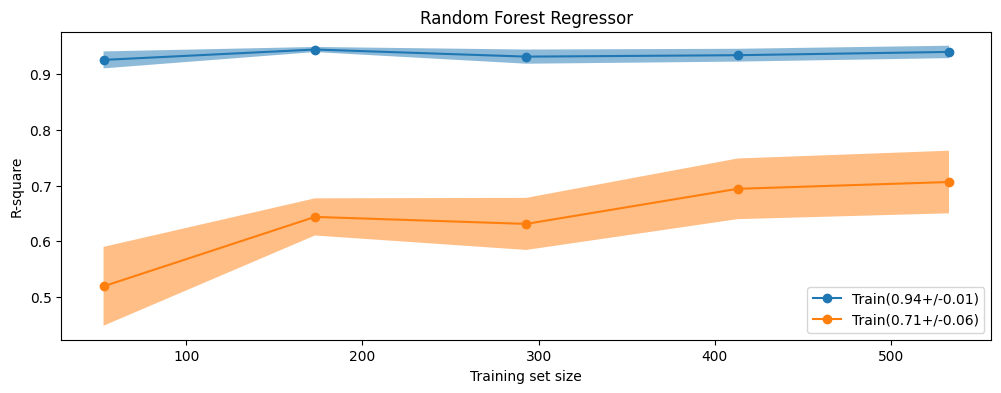

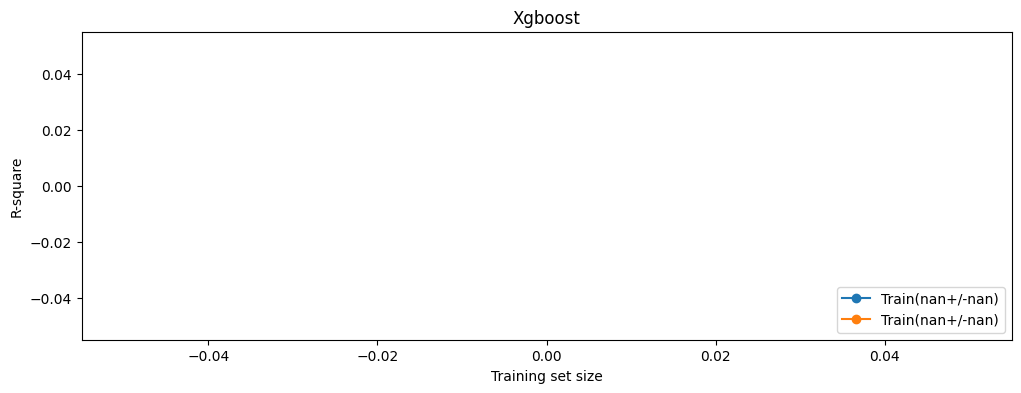

In [51]:
for name,alg in algorithms.items():
    plot_learning_curve(name,alg)

## 6.Model Training

In [52]:
model=Pipeline(steps=[
    ('pre',preprocessor),
    ('rf', RandomForestRegressor(n_estimators=10))
])

In [53]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7. Model Evaluation

In [54]:
def evaluate_model(X,y):
    y_pred=model.predict(X)
    return r2_score(y,y_pred)

In [55]:
print(f"R2 score of tarining model is = {evaluate_model(X_data,y_data)}")

R2 score of tarining model is = 0.9531471114242729


In [56]:
print(f"R2 score of tarining model is = {evaluate_model(X_test,y_test)}")

R2 score of tarining model is = 0.6854318829365948


## 8. Model persistance

In [57]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [58]:
saved_model=joblib.load('model.joblib')

In [59]:
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [60]:
y_pred=saved_model.predict(X_test)

In [61]:
r2_score(y_test,y_pred)

0.6854318829365948